In [1]:
pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 20.9 MB/s eta 0:00:00


In [2]:
pip install pytesseract

In [3]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import os
import re
import pytesseract


In [5]:
def preprocess_plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    gray = cv2.fastNlMeansDenoising(gray, h=10)


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(gray)



    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(contrast, -1, kernel)


    sharpened = cv2.resize(sharpened, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)


    _, thresh = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresh


In [7]:
def ocr_plate(plate_img):

    config = "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 -l eng --oem 3 --psm 7"
    text = pytesseract.image_to_string(plate_img, config=config)

    text = text.strip()
    text = text.replace(" ", "").replace("\n", "")

    text = "".join([c for c in text if c.isalnum()])
    return text



In [8]:
from ultralytics import YOLO
model = YOLO('yolo11x.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
def find_number_plate_dl(img_path, image):
  results = model(img_path)
  plate_crops_and_bboxes = []

  for r in results:
      for box in r.boxes:
          x1, y1, x2, y2 = map(int, box.xyxy[0])
          cropped_img = image[y1:y2, x1:x2]
          plate_crops_and_bboxes.append((cropped_img, (x1, y1, x2-x1, y2-y1)))
  return plate_crops_and_bboxes

In [10]:
def extract_license_number(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)

    plate_crops_and_bboxes = find_number_plate_dl(image_path, img)
    final_results = []

    reader = easyocr.Reader(['en'])

    for item in plate_crops_and_bboxes:
        if not (isinstance(item, tuple) and len(item) == 2):
            print(f"Warning: Skipping malformed item in plate_crops_and_bboxes. Expected (image, bbox), got {item}")
            continue
        cropped_img, bbox = item


        easyocr_results = reader.readtext(cropped_img)
        detected_text_easyocr = []
        confidences_easyocr = []
        for (bbox_ocr, text_ocr, prob_ocr) in easyocr_results:
            detected_text_easyocr.append(text_ocr)
            confidences_easyocr.append(prob_ocr)

        full_text_easyocr = "".join(detected_text_easyocr).replace(" ", "").replace("\n", "").upper()
        avg_confidence_easyocr = np.mean(confidences_easyocr) if confidences_easyocr else 0.0


        pytesseract_text = ocr_plate(cropped_img)
        pytesseract_text = "".join([c for c in pytesseract_text if c.isalnum()]).upper()

        selected_text = ""
        selected_confidence = 0.0


        if avg_confidence_easyocr >= 0.6:
            selected_text = full_text_easyocr
            selected_confidence = avg_confidence_easyocr
        elif pytesseract_text and len(pytesseract_text) > 3 and pytesseract_text.isalnum():
            selected_text = pytesseract_text


            selected_confidence = avg_confidence_easyocr if avg_confidence_easyocr > 0 else 0.4
        else:
            selected_text = full_text_easyocr
            selected_confidence = avg_confidence_easyocr


        if selected_confidence >= 0.4:
            final_results.append((selected_text, bbox, selected_confidence))



        plt.imshow(cropped_img)
        plt.title(f"Detected: {selected_text} (Conf: {selected_confidence:.2f})")
        plt.show()

    final_results.sort(key=lambda x: x[2], reverse=True)

    if final_results:
        print("\n--- DL Model Detections ---")
        for text, bbox, conf in final_results:
            print(f"Detected: {text} (Confidence: {conf:.2f}) at BBox: {bbox}")

    return final_results

Processing images in folder: /content/sample_data/images
Found image files: ['download (6).jpg', 'images (1).jpg', 'images.jpeg', 'download (2).jpg', 'WhatsApp Image 2025-11-08 at 13.45.10_43d27fa8.jpg', 'download (3).jpg', 'WhatsApp Image 2025-11-08 at 13.45.11_6746cf30.jpg', 'images.jpg', 'download.jpg', 'images (4).jpg', 'download (4).jpg', 'download (5).jpg']

Processing: /content/sample_data/images/download (6).jpg

image 1/1 /content/sample_data/images/download (6).jpg: 480x640 1 car, 3746.0ms
Speed: 4.4ms preprocess, 3746.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


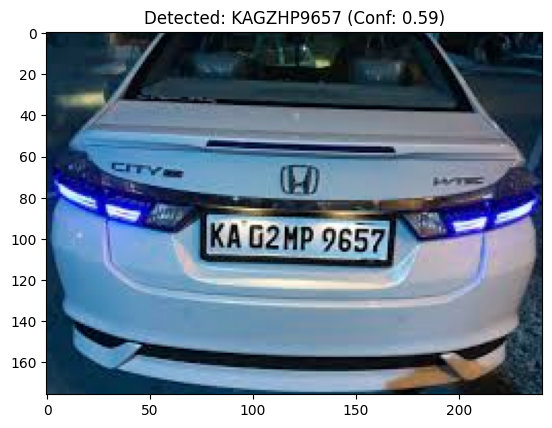


--- DL Model Detections ---
Detected: KAGZHP9657 (Confidence: 0.59) at BBox: (13, 0, 241, 176)
Final Detected Plate: KAGZHP9657 (Confidence: 0.59) BBox: (13, 0, 241, 176)

Processing: /content/sample_data/images/images (1).jpg

image 1/1 /content/sample_data/images/images (1).jpg: 384x640 1 oven, 2215.7ms
Speed: 3.2ms preprocess, 2215.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


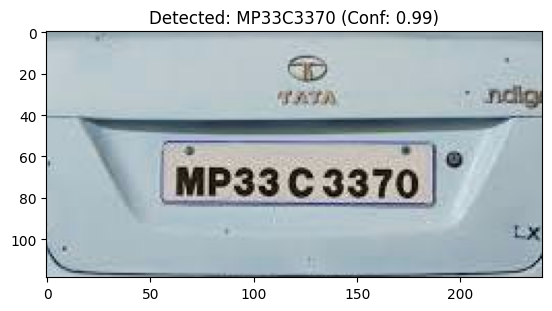


--- DL Model Detections ---
Detected: MP33C3370 (Confidence: 0.99) at BBox: (0, 3, 240, 119)
Final Detected Plate: MP33C3370 (Confidence: 0.99) BBox: (0, 3, 240, 119)

Processing: /content/sample_data/images/images.jpeg

image 1/1 /content/sample_data/images/images.jpeg: 480x640 1 person, 5 cars, 2743.9ms
Speed: 4.0ms preprocess, 2743.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


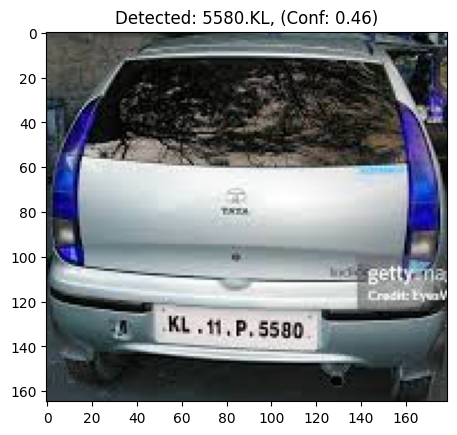

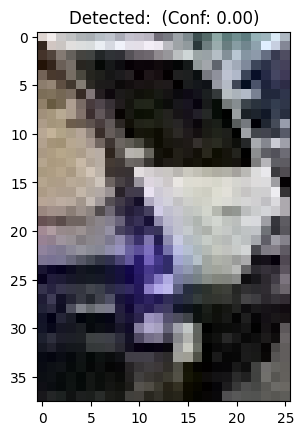

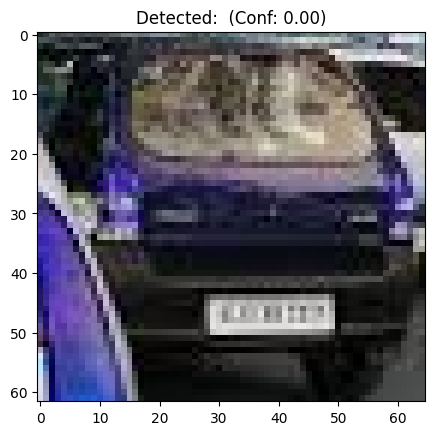

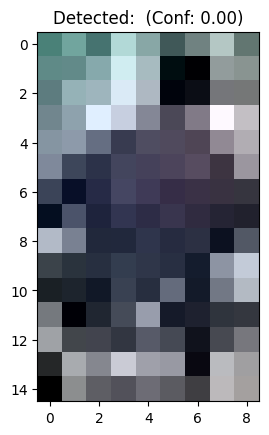

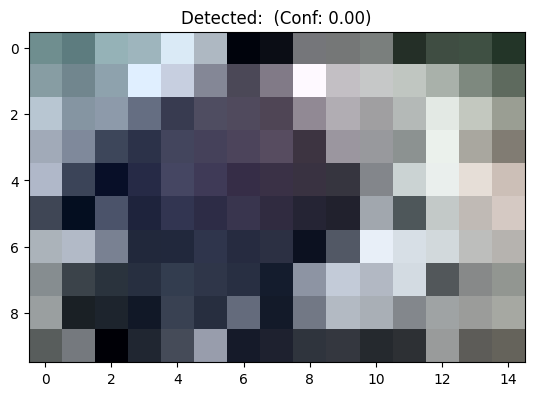

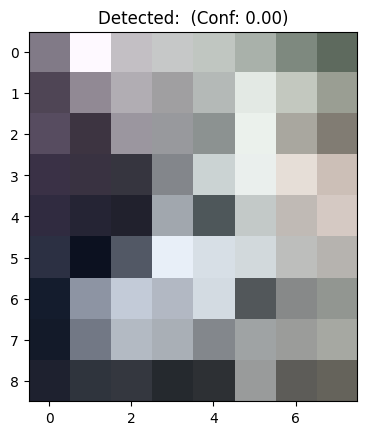


--- DL Model Detections ---
Detected: 5580.KL, (Confidence: 0.46) at BBox: (14, 17, 179, 165)
Final Detected Plate: 5580.KL, (Confidence: 0.46) BBox: (14, 17, 179, 165)

Processing: /content/sample_data/images/download (2).jpg

image 1/1 /content/sample_data/images/download (2).jpg: 384x640 2 cars, 2 trucks, 2603.7ms
Speed: 3.2ms preprocess, 2603.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


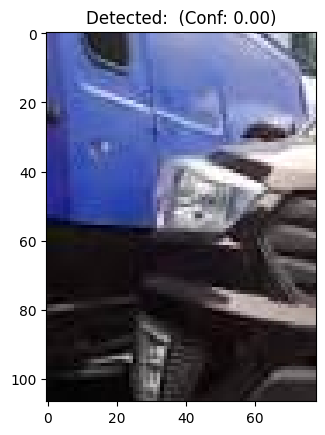

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


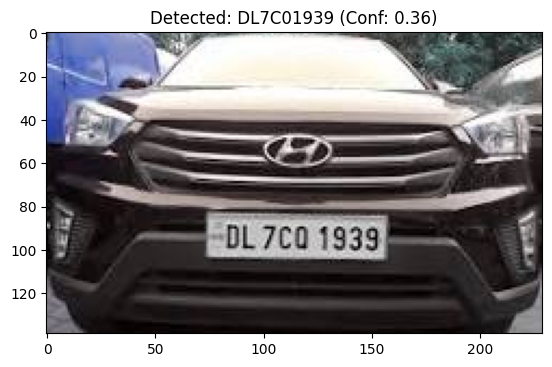

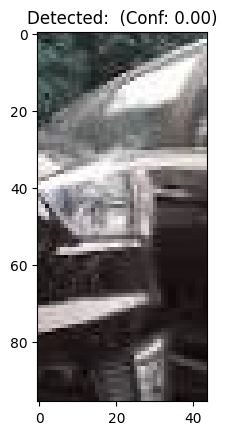

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


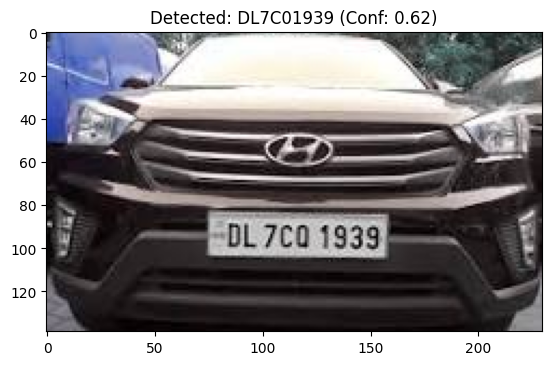


--- DL Model Detections ---
Detected: DL7C01939 (Confidence: 0.62) at BBox: (22, 5, 230, 139)
Final Detected Plate: DL7C01939 (Confidence: 0.62) BBox: (22, 5, 230, 139)

Processing: /content/sample_data/images/WhatsApp Image 2025-11-08 at 13.45.10_43d27fa8.jpg

image 1/1 /content/sample_data/images/WhatsApp Image 2025-11-08 at 13.45.10_43d27fa8.jpg: 448x640 1 car, 2549.5ms
Speed: 4.3ms preprocess, 2549.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


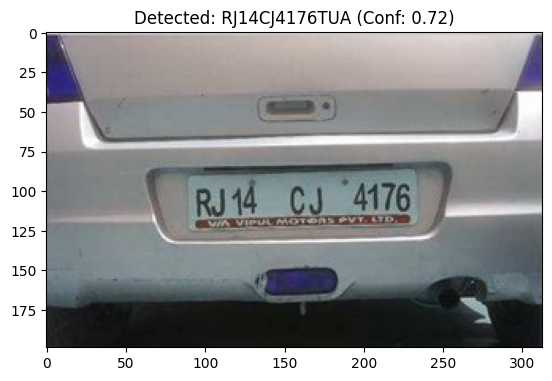


--- DL Model Detections ---
Detected: RJ14CJ4176TUA (Confidence: 0.72) at BBox: (4, 7, 313, 199)
Final Detected Plate: RJ14CJ4176TUA (Confidence: 0.72) BBox: (4, 7, 313, 199)

Processing: /content/sample_data/images/download (3).jpg

image 1/1 /content/sample_data/images/download (3).jpg: 384x640 1 car, 2190.4ms
Speed: 3.5ms preprocess, 2190.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


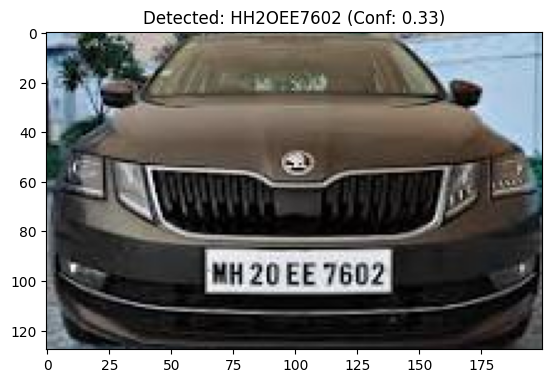

No plate detected with sufficient confidence in download (3).jpg

Processing: /content/sample_data/images/WhatsApp Image 2025-11-08 at 13.45.11_6746cf30.jpg

image 1/1 /content/sample_data/images/WhatsApp Image 2025-11-08 at 13.45.11_6746cf30.jpg: 448x640 (no detections), 2565.6ms
Speed: 4.9ms preprocess, 2565.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


No plate detected with sufficient confidence in WhatsApp Image 2025-11-08 at 13.45.11_6746cf30.jpg

Processing: /content/sample_data/images/images.jpg

image 1/1 /content/sample_data/images/images.jpg: 544x640 1 parking meter, 3103.8ms
Speed: 4.0ms preprocess, 3103.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


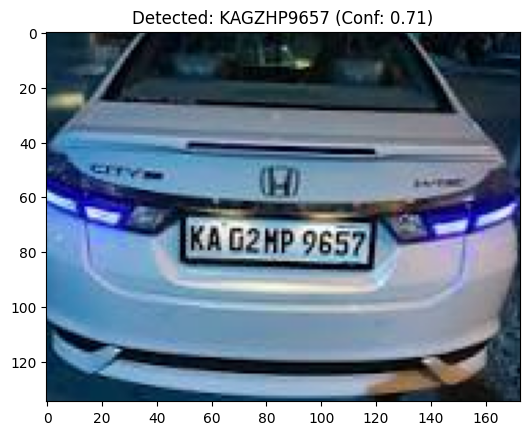


--- DL Model Detections ---
Detected: KAGZHP9657 (Confidence: 0.71) at BBox: (0, 0, 173, 135)
Final Detected Plate: KAGZHP9657 (Confidence: 0.71) BBox: (0, 0, 173, 135)

Processing: /content/sample_data/images/download.jpg

image 1/1 /content/sample_data/images/download.jpg: 576x640 2 cars, 1 parking meter, 3684.1ms
Speed: 5.0ms preprocess, 3684.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 640)


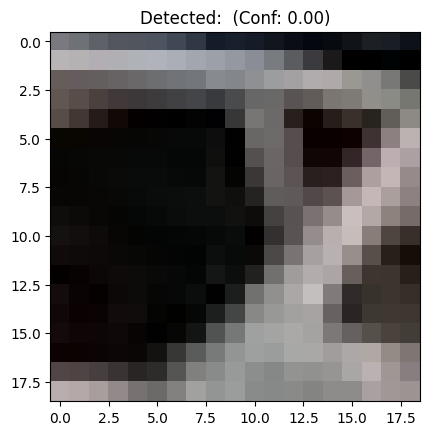

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


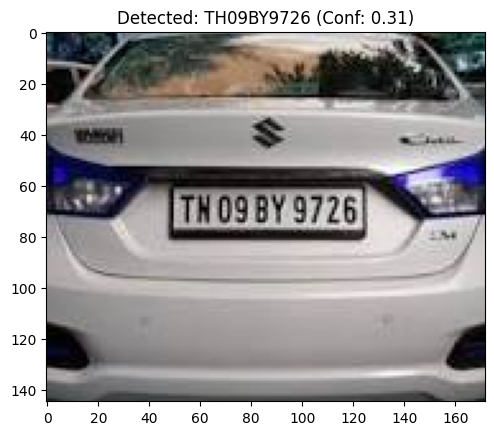

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


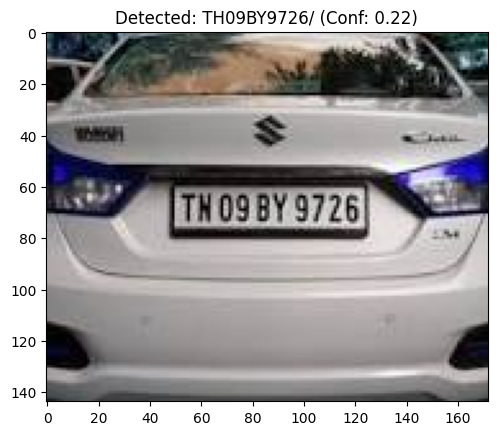

No plate detected with sufficient confidence in download.jpg

Processing: /content/sample_data/images/images (4).jpg

image 1/1 /content/sample_data/images/images (4).jpg: 384x640 (no detections), 2225.6ms
Speed: 5.2ms preprocess, 2225.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


No plate detected with sufficient confidence in images (4).jpg

Processing: /content/sample_data/images/download (4).jpg

image 1/1 /content/sample_data/images/download (4).jpg: 256x640 4 cars, 1733.7ms
Speed: 2.6ms preprocess, 1733.7ms inference, 3.4ms postprocess per image at shape (1, 3, 256, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


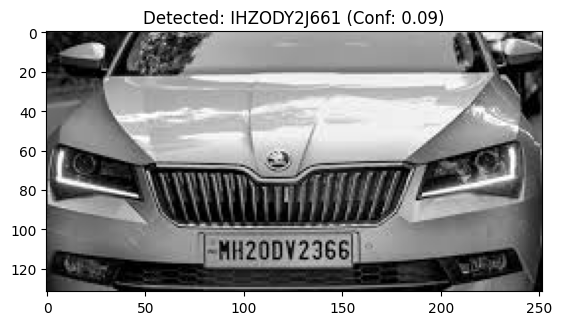

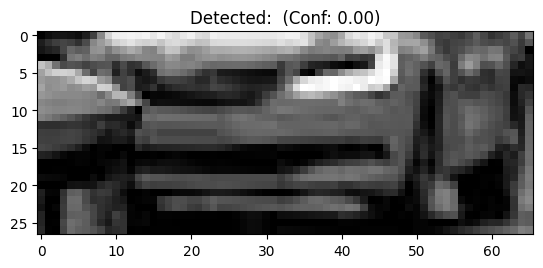

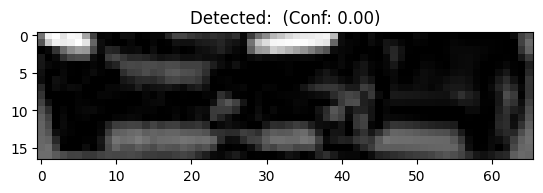

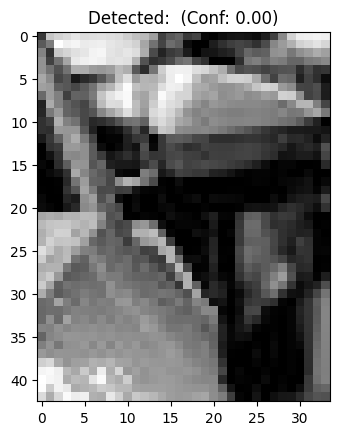

No plate detected with sufficient confidence in download (4).jpg

Processing: /content/sample_data/images/download (5).jpg

image 1/1 /content/sample_data/images/download (5).jpg: 448x640 (no detections), 2525.7ms
Speed: 4.2ms preprocess, 2525.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


No plate detected with sufficient confidence in download (5).jpg


In [13]:
if __name__ == "__main__":
    folder_path = r"/content/sample_data/images"


    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    print(f"Processing images in folder: {folder_path}")
    print(f"Found image files: {image_files}")


    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        print(f"\nProcessing: {image_path}")

        matches = extract_license_number(image_path)

        if matches:
            for txt, bbox, confidence in matches:
                print(f"Final Detected Plate: {txt} (Confidence: {confidence:.2f}) BBox: {bbox}")
        else:
            print(f"No plate detected with sufficient confidence in {filename}")